<h1><center>IMT2118 - Ciencia de Datos Geoespaciales (2024-1) </center></h1>
<h2><center>Proyecto:   </center></h2>

In [3]:
import pandas as pd
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
import geemap, ee
# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()


In [ ]:
stgo = gpd.read_file("Datos/santiago_urbano.gpkg")
roi = geemap.geopandas_to_ee(stgo).geometry()

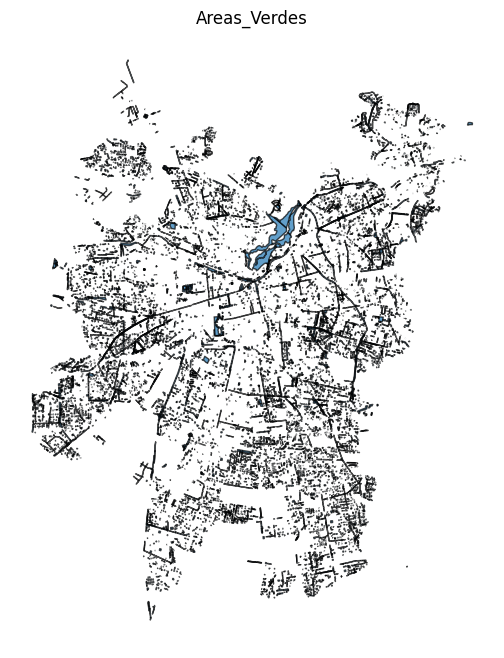

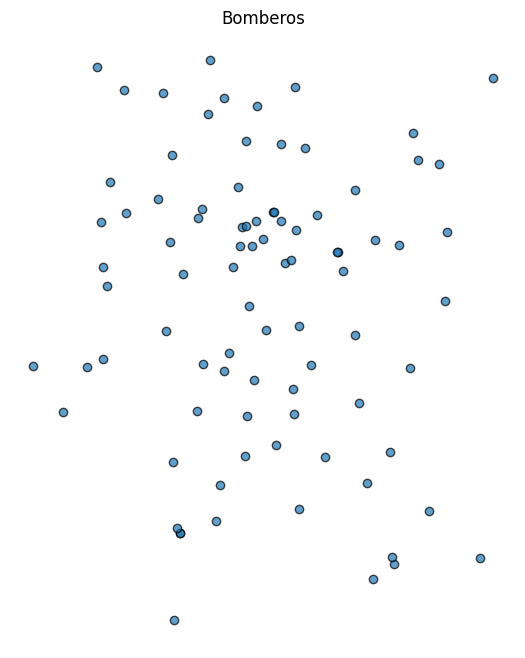

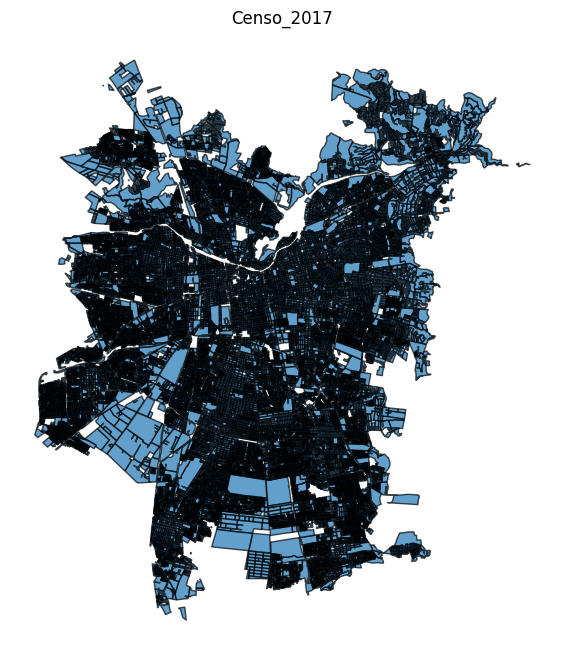

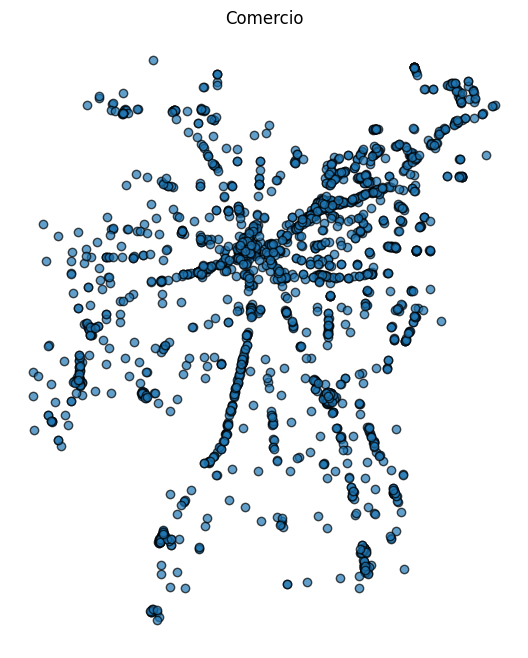

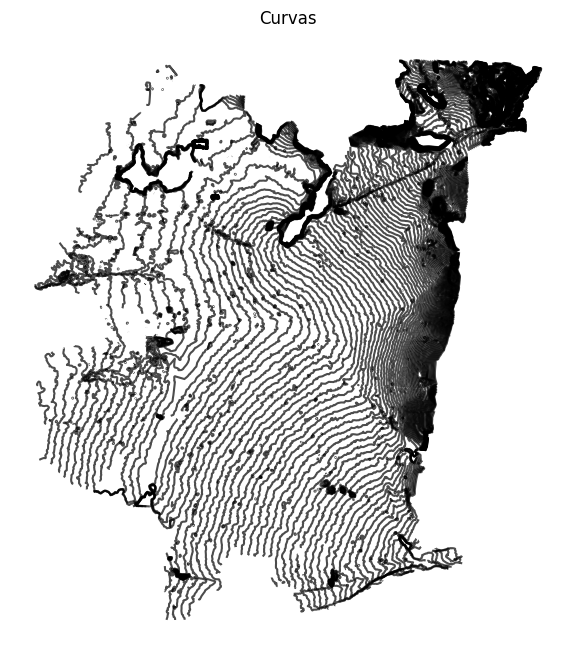

C:\Users\frncc\AppData\Local\Temp\ipykernel_14412\3875505209.py:19: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf.plot(ax=ax, edgecolor='black', alpha=0.7)


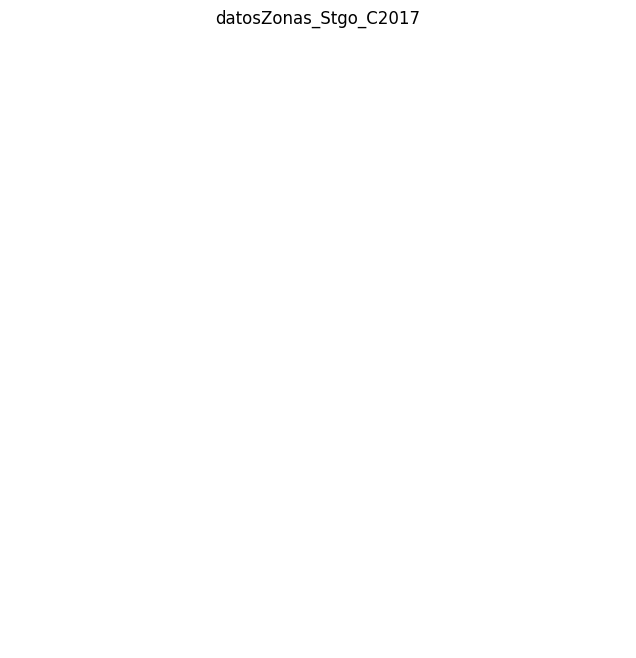

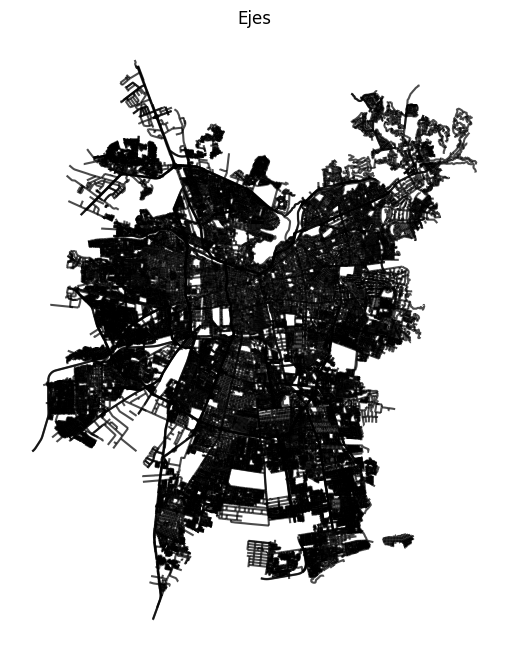

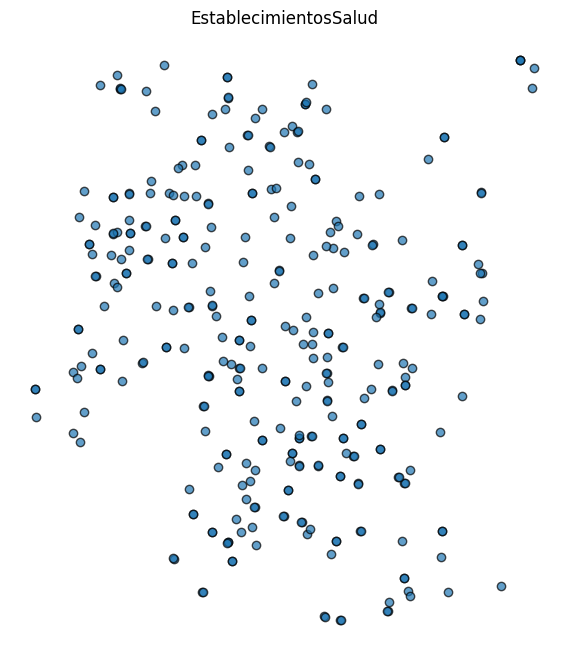

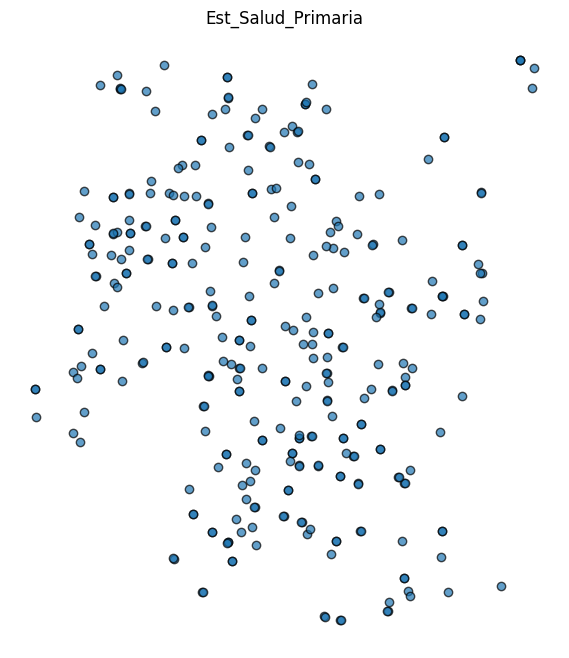

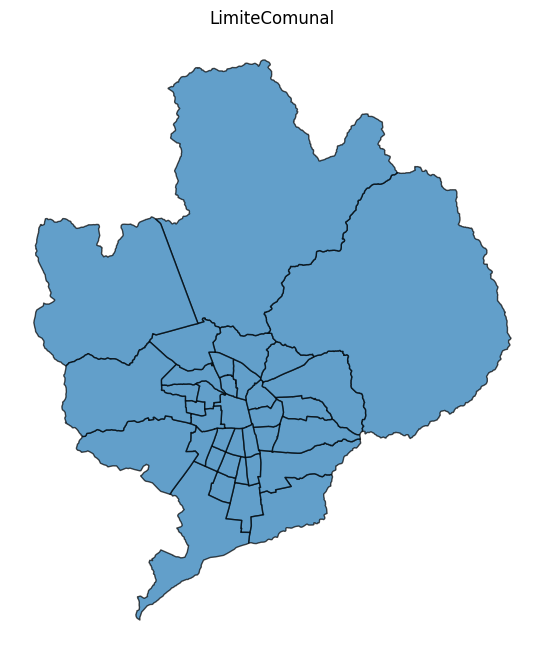

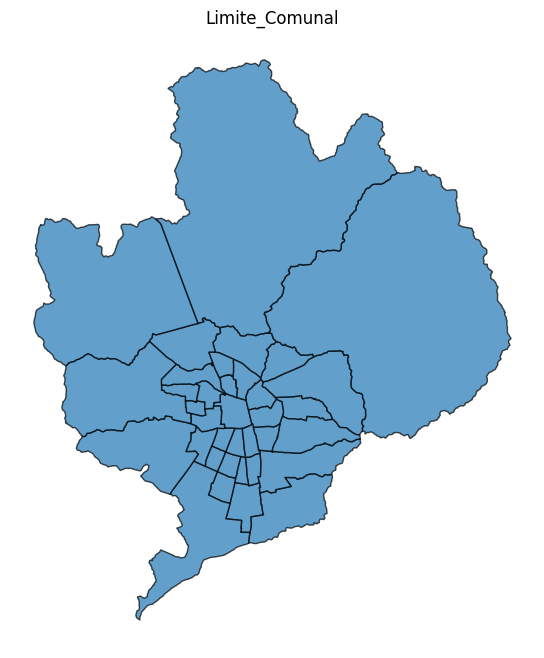

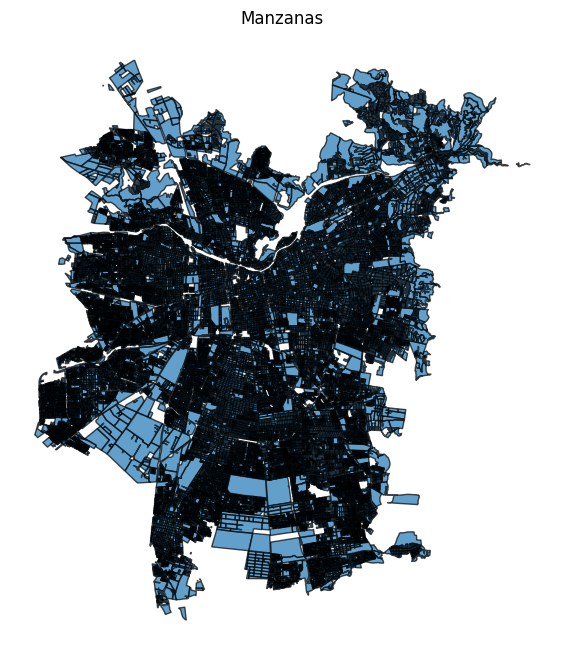

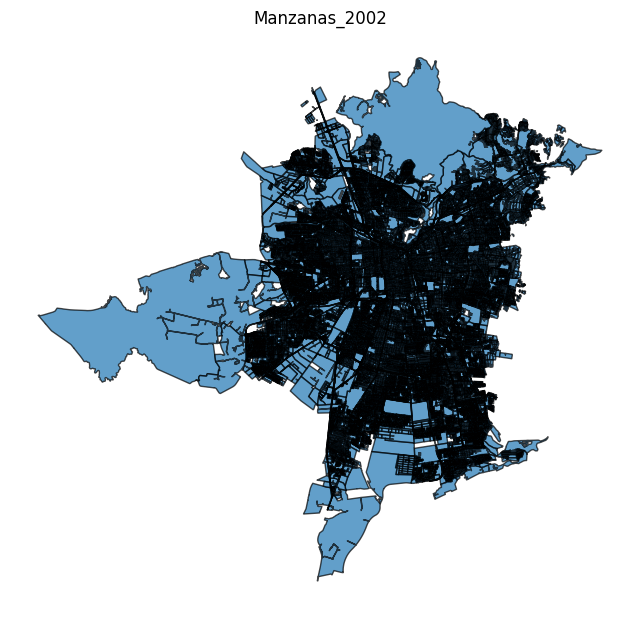

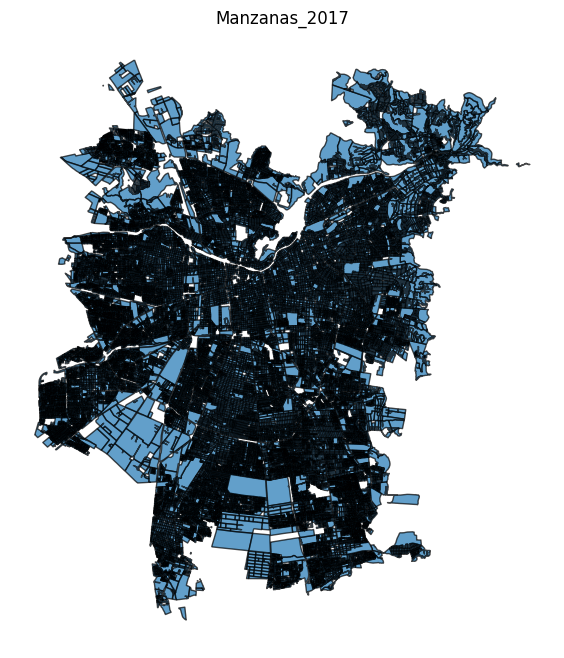

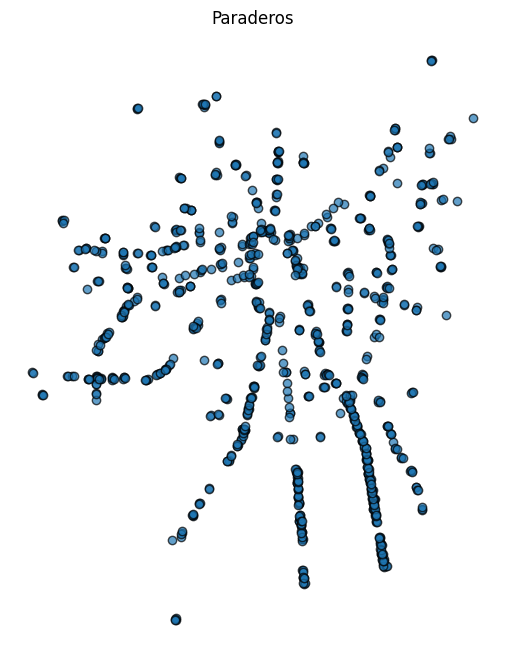

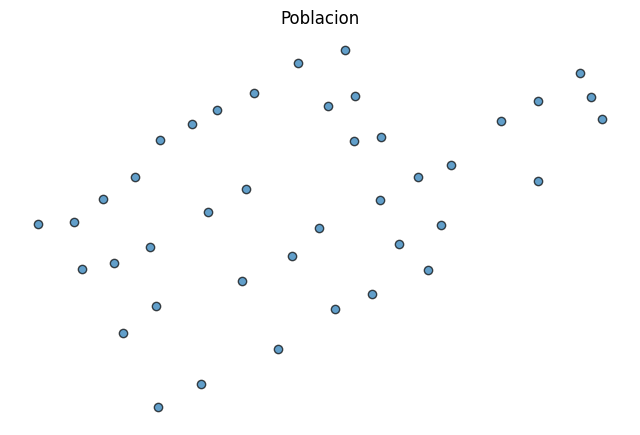

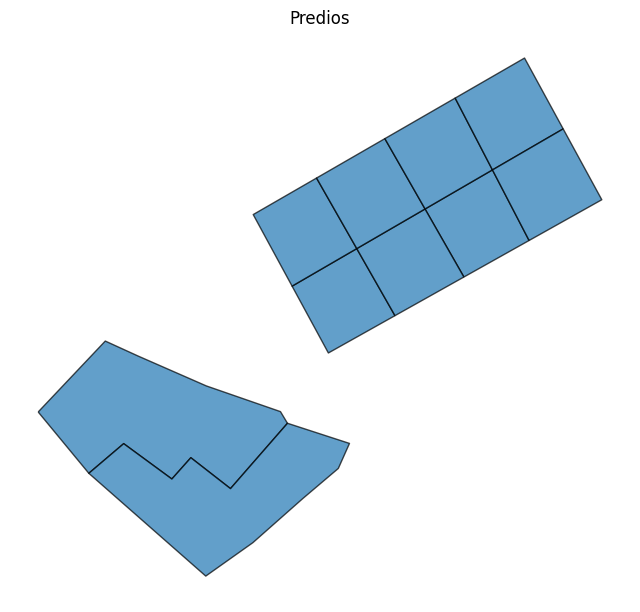

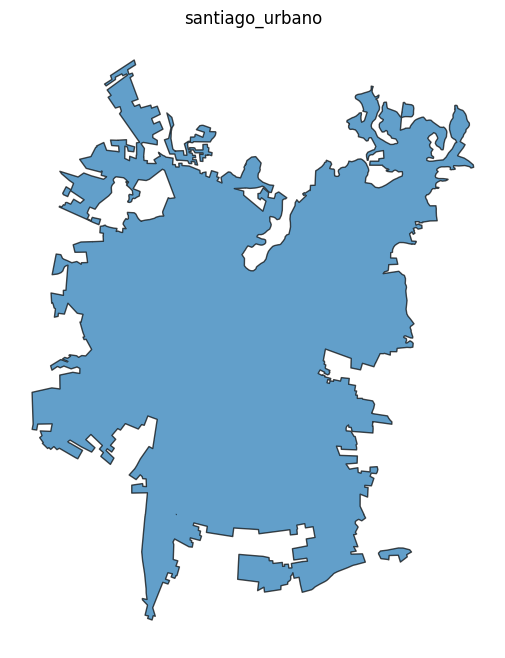

In [12]:
import os

# Leer todos los archivos .gpkg en la carpeta Datos
archivos = [f for f in os.listdir("Datos") if f.endswith(".gpkg")]

gdfs = {}

for archivo in archivos:
    nombre = os.path.splitext(archivo)[0]
    gdf = gpd.read_file(os.path.join("Datos", archivo))

    # ROI
    gdf = gdf[gdf.geometry.intersects(stgo.geometry.iloc[0])]
    gdfs[nombre] = gdf

# Graficar cada GeoDataFrame por separado
for nombre, gdf in gdfs.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf.plot(ax=ax, edgecolor='black', alpha=0.7)
    ax.set_title(f"{nombre}")
    ax.axis('off')
    plt.show()

In [ ]:
# Lista de capas a excluir
excluir = ['Manzanas_2002', 'LimiteComunal', 'Limite_Comunal', 'Curvas', 'Predios']

# Crear el mapa centrado en Santiago
m = geemap.Map(center=[-33.45, -70.65], zoom=11)

# Añadir las capas que no están en la lista de exclusión
for nombre, gdf in gdfs.items():
    if nombre not in excluir and not gdf.empty:
        m.add_gdf(gdf, layer_name=nombre)

m


In [ ]:
# Lista de capas a excluir
excluir = ['Manzanas_2002', 'LimiteComunal', 'Limite_Comunal', 'Curvas', 'Predios']

# Crear el mapa centrado en Santiago
m = geemap.Map(center=[-33.45, -70.65], zoom=11)

# Añadir las capas que no están en la lista de exclusión
for nombre, gdf in :
    if nombre not in excluir and not gdf.empty:
        m.add_gdf(gdf, layer_name=nombre,     marker_type='circle'  # ⬅️ Esta línea hace la magia
)

m


Map(center=[-33.45, -70.65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…